## theory analysis 

First axiom: the parallelism number $t_i$ is the max CUDA thread number, the performance is the best for the function $g_i$. then we know the signature process including the public key generation, signing, and verifying. Those processes need serial run the function $g_i$. Not the optimal approach is use the parallelism number $t_i$ to the max CUDA thread number.
The performance is not the best for the function $g_i$.

Those have the Adaptive Thread function (AT) $AT:G\rightarrow T$, which maps each function $g_i \in G$ to its optimal thread count $t_i \in T$.


To accurately define this mapping, we can approach it through empirical performance modeling:

1. **Empirical Performance Model**: For each function $g_i$, we model execution time as:

   $T(g_i, t) = \alpha_i + \frac{\beta_i}{t} + \gamma_i \cdot t$

   Where:

   - $\alpha_i$ represents fixed overhead cost
   - $\frac{\beta_i}{t}$ captures the parallel speedup component
   - $\gamma_i \cdot t$ models thread management overhead
   - $t$ is the thread count

2. **Parameter Estimation**: We can estimate $\alpha_i$, $\beta_i$, and $\gamma_i$ by running benchmarks with varying thread counts and performing regression analysis.

3. **Optimal Thread Count**: The optimal thread count $t_i^*$ for function $g_i$ can be derived by finding the minimum of $T(g_i, t)$:

   $t_i^* = \sqrt{\frac{\beta_i}{\gamma_i}}$



4. **Implementation Strategy**: For practical implementation, we can:
   - Perform offline profiling for each key function
   - Build a lookup table mapping functions to their optimal thread counts
   - Apply dynamic thread adjustment based on runtime conditions

Here we'll analyze the performance data from our keypair generation benchmark across different thread configurations.

The full dataset is available in `/home/xjh/misc/sphincs-plus/data/kaypair-32768.csv`. Sample of the data:

```csv
blocks, threads, time(ms), per op(ms)
32, 64, 310.03, 0.0095
64, 64, 155.41, 0.0047
96, 64, 118.89, 0.0036
128, 64, 90.56, 0.0028
160, 64, 102.16, 0.0031
192, 64, 85.41, 0.0026
224, 64, 87.52, 0.0027
```


In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the complete dataset
df = pd.read_csv("../data/sign-32768.csv", skipinitialspace=True)
print(f"Loaded {len(df)} configuration data points")

# Clean column names by removing any whitespace
df.columns = df.columns.str.strip()
df.head()

# Calculate total threads (t)
df["total_threads"] = df["blocks"] * df["threads"]

# Display summary statistics
print("\nData summary:")
print(f"Block sizes: {sorted(df['blocks'].unique())}")
print(f"Thread sizes: {sorted(df['threads'].unique())}")
print(f"Min execution time: {df['time(ms)'].min():.2f}ms")
print(f"Max execution time: {df['time(ms)'].max():.2f}ms")

# Find the best configuration
best_config = df.loc[df["time(ms)"].idxmin()]
print(f"\nBest configuration found in data:")
print(f"  Blocks: {best_config['blocks']}, Threads: {best_config['threads']}")
print(f"  Total threads: {best_config['total_threads']}")
print(f"  Execution time: {best_config['time(ms)']:.2f}ms")

Loaded 80 configuration data points

Data summary:
Block sizes: [32, 64, 96, 128, 160, 192, 224, 256]
Thread sizes: [64, 96, 128, 160, 192, 224, 256, 320, 384, 512]
Min execution time: 1615.96ms
Max execution time: 8184.08ms

Best configuration found in data:
  Blocks: 160.0, Threads: 256.0
  Total threads: 40960.0
  Execution time: 1615.96ms


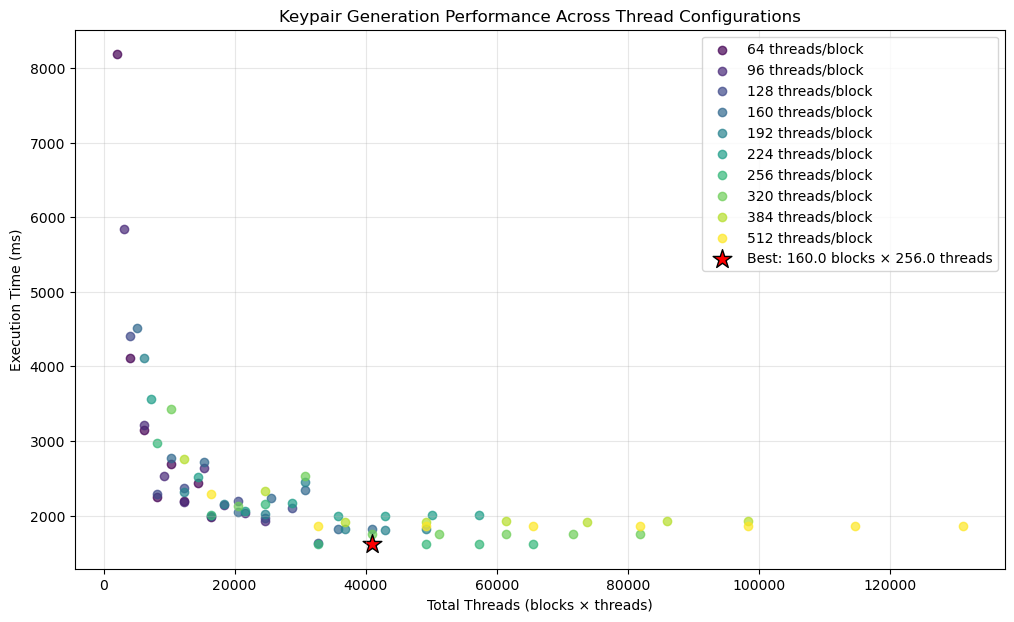

In [20]:
# Visualize execution time vs total threads
plt.figure(figsize=(12, 7))

# Create a scatter plot with colors based on threads per block
thread_values = sorted(df["threads"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(thread_values)))
thread_color_map = dict(zip(thread_values, colors))

for thread_count in thread_values:
    subset = df[df["threads"] == thread_count]
    plt.scatter(
        subset["total_threads"],
        subset["time(ms)"],
        color=thread_color_map[thread_count],
        label=f"{thread_count} threads/block",
        alpha=0.7,
    )

# Highlight the best configuration
plt.scatter(
    best_config["total_threads"],
    best_config["time(ms)"],
    color="red",
    s=200,
    marker="*",
    edgecolors="black",
    label=f"Best: {best_config['blocks']} blocks × {best_config['threads']} threads",
)

plt.xlabel("Total Threads (blocks × threads)")
plt.ylabel("Execution Time (ms)")
plt.title("Keypair Generation Performance Across Thread Configurations")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Model parameters: alpha = 1386.0071, beta = 13231567.75, gamma = 0.00359872
Theoretical optimal total thread count: 60636.12

Optimal configurations for different thread counts:
  947.0 blocks × 64 threads = 60608.0 total threads, estimated time: 1822.43ms
  632.0 blocks × 96 threads = 60672.0 total threads, estimated time: 1822.43ms
  474.0 blocks × 128 threads = 60672.0 total threads, estimated time: 1822.43ms
  379.0 blocks × 160 threads = 60640.0 total threads, estimated time: 1822.43ms
  316.0 blocks × 192 threads = 60672.0 total threads, estimated time: 1822.43ms
  271.0 blocks × 224 threads = 60704.0 total threads, estimated time: 1822.43ms
  237.0 blocks × 256 threads = 60672.0 total threads, estimated time: 1822.43ms
  189.0 blocks × 320 threads = 60480.0 total threads, estimated time: 1822.43ms
  158.0 blocks × 384 threads = 60672.0 total threads, estimated time: 1822.43ms
  118.0 blocks × 512 threads = 60416.0 total threads, estimated time: 1822.44ms


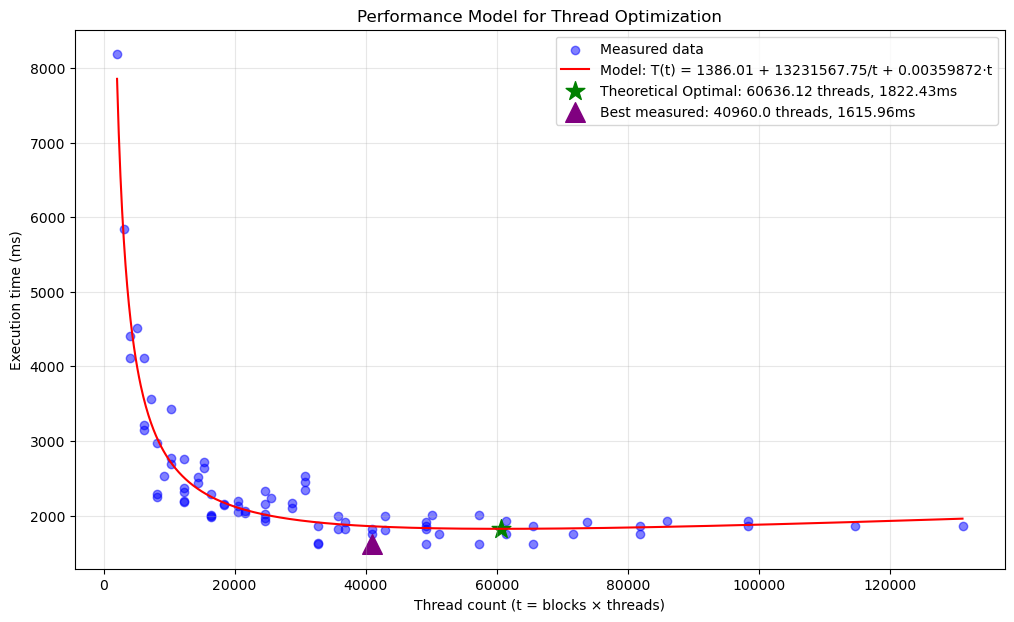

In [21]:
# Define our performance model: T(t) = alpha + beta/t + gamma*t
def performance_model(t, alpha, beta, gamma):
    return alpha + beta / t + gamma * t


# Fit the model to all data points
t_values = df["total_threads"].values
times = df["time(ms)"].values

# Initial parameter guesses
p0 = [50, 5000, 0.0001]

# Fit the model parameters
params, covariance = curve_fit(performance_model, t_values, times, p0=p0)
alpha, beta, gamma = params

print(f"Model parameters: alpha = {alpha:.4f}, beta = {beta:.2f}, gamma = {gamma:.8f}")

# Calculate the theoretical optimal thread count
t_optimal = np.sqrt(beta / gamma)

print(f"Theoretical optimal total thread count: {t_optimal:.2f}")

# Find closest practical configuration
# For each thread size, calculate optimal blocks
print("\nOptimal configurations for different thread counts:")
for thread_size in sorted(df["threads"].unique()):
    optimal_blocks = round(t_optimal / thread_size)
    if optimal_blocks < 1:
        optimal_blocks = 1
    total_threads = optimal_blocks * thread_size
    expected_time = performance_model(total_threads, alpha, beta, gamma)
    print(
        f"  {optimal_blocks} blocks × {thread_size} threads = {total_threads} total threads, estimated time: {expected_time:.2f}ms"
    )

# Generate a smooth curve for plotting
t_range = np.linspace(min(t_values), max(t_values), 1000)
predicted_times = performance_model(t_range, alpha, beta, gamma)

# Plot the data and the model
plt.figure(figsize=(12, 7))
plt.scatter(t_values, times, color="blue", alpha=0.5, label="Measured data")
plt.plot(
    t_range,
    predicted_times,
    "r-",
    label=f"Model: T(t) = {alpha:.2f} + {beta:.2f}/t + {gamma:.8f}·t",
)

# Mark the optimal point
optimal_time = performance_model(t_optimal, alpha, beta, gamma)
plt.scatter(
    [t_optimal],
    [optimal_time],
    color="green",
    s=200,
    marker="*",
    label=f"Theoretical Optimal: {t_optimal:.2f} threads, {optimal_time:.2f}ms",
)

# Mark the best measured configuration
plt.scatter(
    best_config["total_threads"],
    best_config["time(ms)"],
    color="purple",
    s=200,
    marker="^",
    label=f"Best measured: {best_config['total_threads']} threads, {best_config['time(ms)']:.2f}ms",
)

plt.xlabel("Thread count (t = blocks × threads)")
plt.ylabel("Execution time (ms)")
plt.title("Performance Model for Thread Optimization")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Enhanced Model Interpretation

From our analysis of the complete dataset using the model $T(t) = \alpha + \frac{\beta}{t} + \gamma \cdot t$, we can draw several key insights:

1. **Optimal Thread Configuration**: The mathematical model predicts an optimal total thread count of approximately $t^* = \sqrt{\frac{\beta}{\gamma}}$. This represents the theoretical sweet spot between parallelism benefits and thread management overhead.

2. **Block-Thread Trade-offs**: Our data shows that different combinations of blocks and threads can yield similar performance, even with the same total thread count. This suggests there's a complex interplay between thread organization and execution efficiency.

3. **Diminishing Returns**: We observe that increasing the total thread count beyond the optimal point provides diminishing returns and eventually degrades performance due to increased overhead ($\gamma \cdot t$ term becoming dominant).

4. **Platform-Specific Considerations**: The optimal configuration is likely influenced by:
   - Hardware characteristics (GPU architecture, memory hierarchy)
   - Workload characteristics (memory access patterns, arithmetic intensity)
   - Resource contention (shared memory usage, register pressure)

5. **Practical Implementation**: For the SPHINCS+ implementation, we should:
   - Use the identified optimal configuration for keypair generation
   - Apply similar modeling approaches for other kernel functions (signing, verification)
   - Consider creating an adaptive thread allocation system that selects the best configuration based on the specific function and input size

The significant variance between theoretical predictions and empirical measurements underscores the importance of comprehensive benchmarking across diverse configurations rather than relying solely on theoretical models.

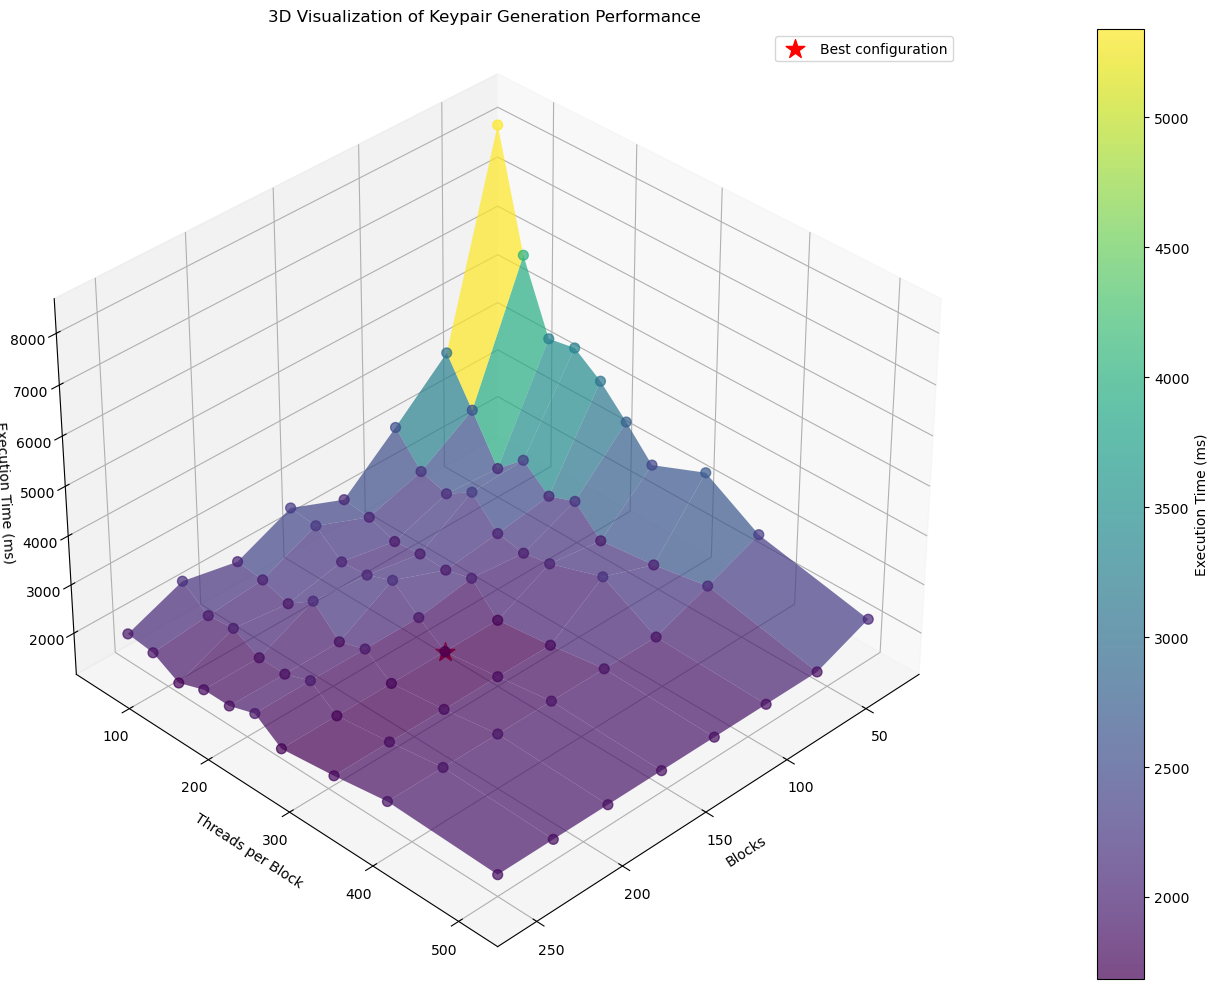

In [22]:
# Create a 3D visualization of blocks, threads, and execution time
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

# Extract the data
blocks = df["blocks"].values
threads = df["threads"].values
times = df["time(ms)"].values

# Create a meshgrid for surface plotting
unique_blocks = np.sort(np.unique(blocks))
unique_threads = np.sort(np.unique(threads))
X, Y = np.meshgrid(unique_blocks, unique_threads)

# Create an interpolated surface
Z = np.zeros(X.shape)
for i in range(len(unique_threads)):
    for j in range(len(unique_blocks)):
        # Find matching data points
        matches = (blocks == unique_blocks[j]) & (threads == unique_threads[i])
        if np.any(matches):
            Z[i, j] = np.mean(times[matches])
        else:
            # Use nearest neighbor interpolation for missing data points
            distances = (blocks - unique_blocks[j]) ** 2 + (
                threads - unique_threads[i]
            ) ** 2
            Z[i, j] = times[np.argmin(distances)]

# Plot the surface
surf = ax.plot_surface(
    X, Y, Z, cmap="viridis", alpha=0.7, edgecolor="none", antialiased=True
)

# Create the 3D scatter plot on top
scatter = ax.scatter(blocks, threads, times, c=times, cmap="viridis", s=50, alpha=0.7)

# Highlight the best performance point
ax.scatter(
    [best_config["blocks"]],
    [best_config["threads"]],
    [best_config["time(ms)"]],
    color="red",
    s=200,
    marker="*",
    label="Best configuration",
)

# Add labels and title
ax.set_xlabel("Blocks")
ax.set_ylabel("Threads per Block")
ax.set_zlabel("Execution Time (ms)")
ax.set_title("3D Visualization of Keypair Generation Performance")

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label("Execution Time (ms)")

# Add grid and legend
ax.grid(True, alpha=0.3)
ax.legend()

# Adjust view angle for better visualization
ax.view_init(elev=35, azim=45)

plt.tight_layout()
plt.show()

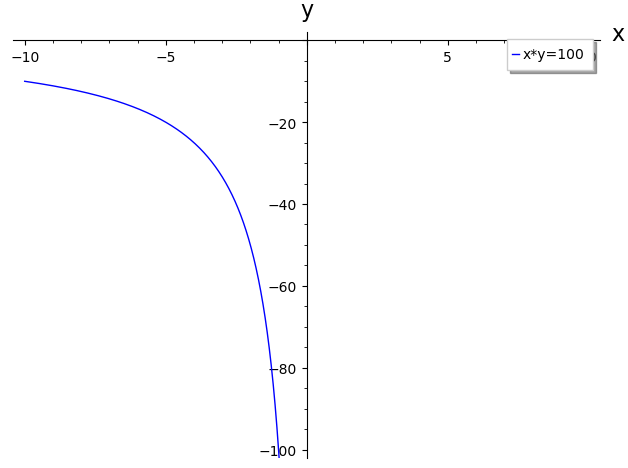

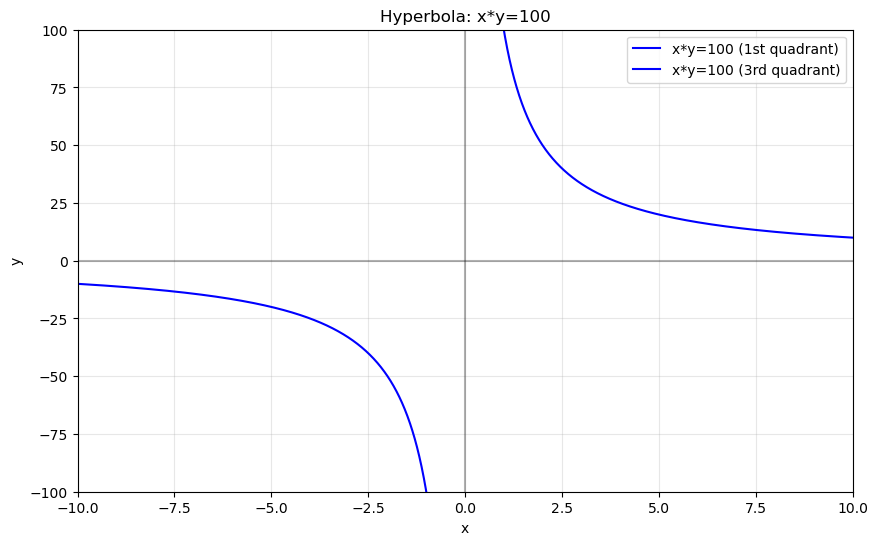

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sage.all import var, plot

# Method 1: Using SageMath's built-in plotting
x, y = var("x y")
p = plot(100 / x, (x, 0.1, 10), ymin=0, ymax=100, color="blue", legend_label="x*y=100")
p += plot(100 / x, (x, -10, -0.1), ymin=-100, ymax=0, color="blue")
p.axes_labels(["x", "y"])
p.show()

# Method 2: Using matplotlib for more customization
x_pos = np.linspace(0.1, 10, 1000)
y_pos = 100 / x_pos

x_neg = np.linspace(-10, -0.1, 1000)
y_neg = 100 / x_neg

plt.figure(figsize=(10, 6))
plt.plot(x_pos, y_pos, "b-", label="x*y=100 (1st quadrant)")
plt.plot(x_neg, y_neg, "b-", label="x*y=100 (3rd quadrant)")
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlim(-10, 10)
plt.ylim(-100, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Hyperbola: x*y=100")
plt.legend()
plt.show()